In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn.plotting import plot_design_matrix

sys.path.append(
    '/Users/jeanettemumford/Dropbox/Research/Projects/patrick/efficiency_rdoc'
)

from utils import (
    calc_avg_prob_next_given_last1_and_last2,
    calc_expected_run_num_by_chance,
    est_eff_and_vif,
    run_eff_sim,
    sample_shifted_truncated_exponential,
)

### Design setup starting point

Here's what we are starting with.

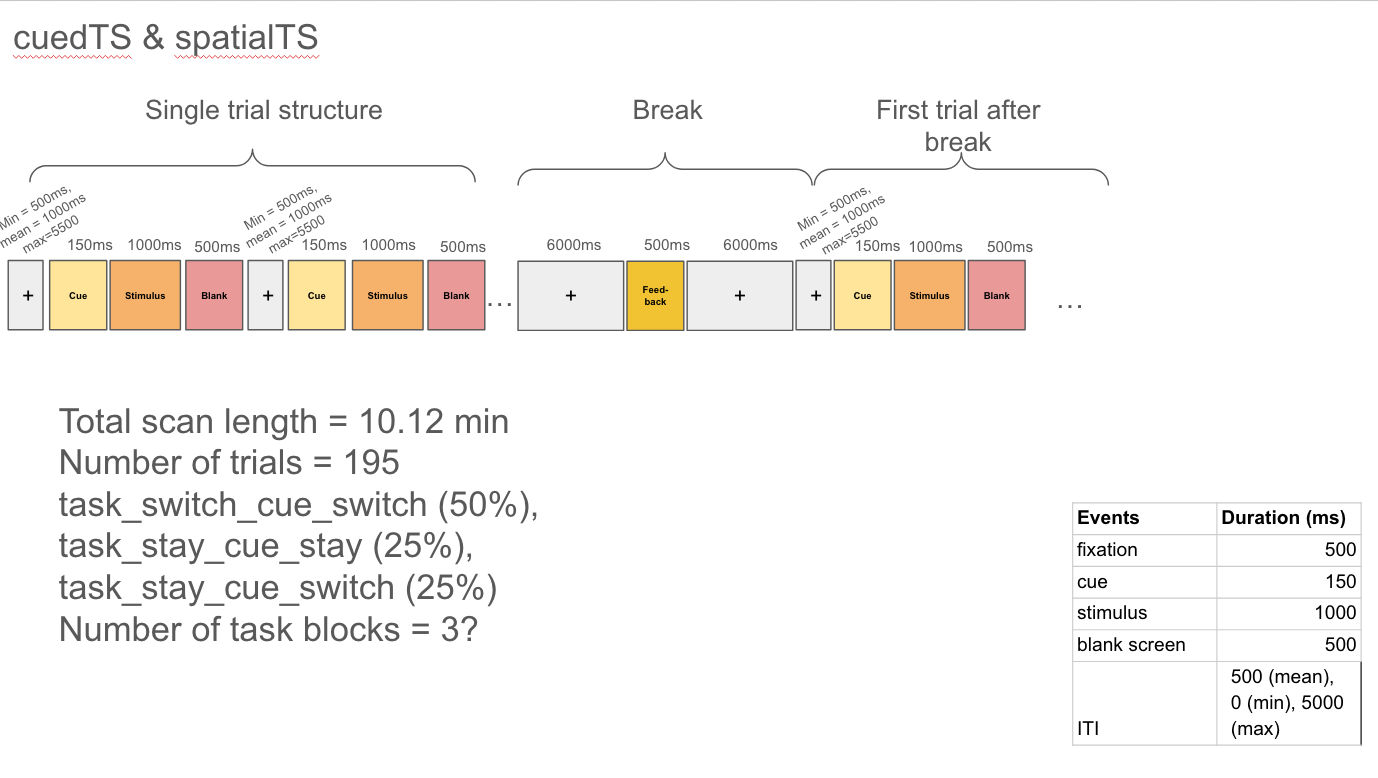

From a modeling perspective we have no choice but to model the cue and stimulus as a single event, since there isn't a break between them.  Given this, the events files that I will be generating will only have cue_and_stimulus events (so a single onset and duration for both parts).

In [2]:
def make_cued_spatial_ts_timings(
    n_tsw_csw,
    n_tst_cst,
    n_tst_csw,
    cue_stim_dur,
    blank_dur,
    nbreaks,
    break_fix_pre_message_dur,
    break_message_dur,
    break_fix_post_message_dur,
    isi_exp_lam,
    isi_truncation,
    isi_shift,
):
    """
    Produces a randomly ordered set of trials for the cued and spatial ts tasks.
    Assumes a break between blocks of task.  Number of tsw_csw/tst_cst/tst_csw trials will be equal
    for each block of the task
    ISI is sampled from a truncated exponential.  Note the truncation value for the
    truncated exponential does *not* include the shift, so the max isi is
    isi_truncation + isi_shift.
    A trial is structured as:
      fixation (based on truncated exponential) +
      cue_stim (cue_stim_dur) + blank (blank_dur) +
      next trial (same structure as above until end of block is reached)
      At end of block the break begins with:
      fixation (length=break_dur) +
      break message (break_message_dur) +
      post message fixation (post_message_dur)
    Input:
      n_tsw_csw, n_tst_cst, n_tst_csw: Total number of tsw_csw/tst_cst/tst_csw trials
          (will be evenly split between blocks) Integer divisible by (nbreaks + 1)
      cue_stim_dur/blank_dur: Durations of cue_stim/blank
      blank_dur:  Duration of blank screen after stop/go stimulus offset
      break_fix_pre_message_dur: Fixation duration at beginning of break (no jittering)
      break_message_dur:  Duration of message shown during break
      break_fix_post_message_dur:  Fixation duration after message (no jittering)
      isi_exp_lam:  (seconds) The lambda parameter of the exponential used for the isi
                    (inverse is the non-truncated/non-shifted mean)
      isi_truncation: (seconds) Truncation value of the exponential *NOT* including shift.
                      Max ISI = isi_truncation + isi_shift
      isi_shift: (seconds) Shift value for isi (minimum isi value)
    Output:
       Events pandas data frame with onsets, trial_type and duration.
    """

    nblocks = nbreaks + 1
    ntrials = n_tsw_csw + n_tst_cst + n_tst_csw + 3  # add 3 for the n/a trials
    ntrials_per_block = int(ntrials / nblocks)
    n_tsw_csw_per_block = int(n_tsw_csw / (nblocks))
    n_tst_cst_per_block = int(n_tst_cst / (nblocks))
    n_tst_csw_per_block = int(n_tst_csw / (nblocks))
    isi_vals, _ = sample_shifted_truncated_exponential(
        isi_exp_lam, isi_truncation, isi_shift, ntrials
    )

    # fragments = all sub-components of the run (go/stop/fixation/blank/break_message)
    # Each stimulus has 3 fragments and each break has 3 fragments
    isi_count = 0
    fragment_durations = []
    fragment_labels = []
    for cur_block in range(nblocks):
        stim_type_block = np.random.permutation(
            np.concatenate(
                (
                    np.repeat(['tsw_csw'], n_tsw_csw_per_block),
                    np.repeat(['tst_cst'], n_tst_cst_per_block),
                    np.repeat(['tst_csw'], n_tst_csw_per_block),
                )
            )
        )
        # add in starter trial (n/a trial)
        stim_type_block = np.insert(stim_type_block, 0, ['start'])
        for cur_trial in range(ntrials_per_block):
            cur_stim_type = stim_type_block[cur_trial]
            fragment_durations.extend([isi_vals[isi_count], cue_stim_dur, blank_dur])
            fragment_labels.extend(['isi_fix', cur_stim_type, 'blank'])
            isi_count = isi_count + 1
        # Add break
        fragment_durations.extend(
            [break_fix_pre_message_dur, break_message_dur, break_fix_post_message_dur]
        )
        fragment_labels.extend(['fix_break', 'break_message', 'fix_break'])

    # If you don't want the beginning of the run to start at 0, change this
    # (e.g. if you want to add the 10s to reach steady state)
    run_start = 0
    fragment_onsets = np.cumsum([run_start] + fragment_durations)[:-1]
    events_data = pd.DataFrame(
        {
            'onset': fragment_onsets,
            'trial_type': fragment_labels,
            'duration': fragment_durations,
        }
    )
    events_data = events_data.loc[
        events_data['trial_type'].str.contains(
            'start|tsw_csw|tst_cst|tst_csw|break_message'
        )
        == True
    ]
    return events_data

In [3]:
events_inputs = {
    'n_tsw_csw': 96,
    'n_tst_cst': 48,
    'n_tst_csw': 48,
    'nbreaks': 2,
    'cue_stim_dur': 1.15,
    'blank_dur': 0.5,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': 0.5,
}

tr = 1.49
total_time = 12 * 60
contrasts = {
    'tsw_csw-tst_csw': 'tsw_csw-tst_csw',
    'tst_csw-tst_cst': 'tst_csw - tst_cst',
    'all_task': '.333*tsw_csw + .333*tst_csw + .333*tst_cst',
}


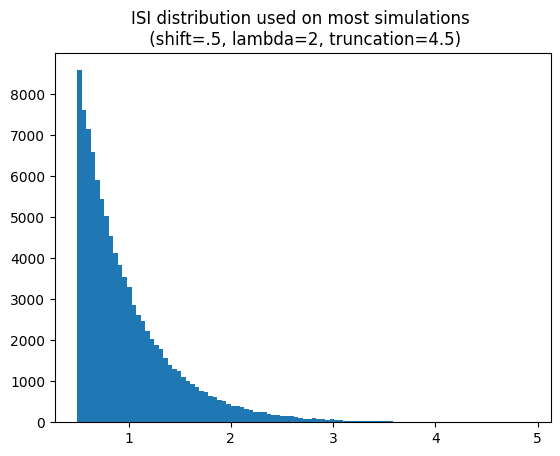

theoretical mean
0.9994445873382422
quartiles
[0.5   0.643 0.845 1.191 4.908]


In [4]:
nsamp = 100000
samples, theoretical_mean = sample_shifted_truncated_exponential(
    events_inputs['isi_exp_lam'],
    events_inputs['isi_truncation'],
    events_inputs['isi_shift'],
    nsamp,
)
isi_quartiles = np.round(np.quantile(samples, [0, 0.25, 0.5, 0.75, 1]), 3)

plt.hist(samples, 100)
plt.title(
    'ISI distribution used on most simulations \n (shift=.5, lambda=2, truncation=4.5)'
)
plt.show()
print('theoretical mean')
print(theoretical_mean)
print('quartiles')
print(isi_quartiles)

In [5]:
# This variable is used later to pull out rows of of the events file and translate
# names into the string integers used to assess the psychological factors
trials_psych_assess_map = {'tsw_csw': '1', 'tst_csw': '2', 'tst_cst': '3'}

unpermuted_trials = np.concatenate(
    [
        np.repeat('1', events_inputs['n_tsw_csw'] / 3),
        np.repeat('2', events_inputs['n_tst_csw'] / 3),
        np.repeat('3', events_inputs['n_tst_cst'] / 3),
    ],
    axis=0,
)
avg_trial_repeats_info = calc_expected_run_num_by_chance(unpermuted_trials, nsims=5000)

for val in ['1', '2', '3']:
    avg_trial_repeats_info[f'{val}_run_counts'] = (
        avg_trial_repeats_info[f'{val}_run_counts'] * 3
    )
print(avg_trial_repeats_info.loc[:25, :])

avg_prob_given_last1, avg_prob_given_last2 = calc_avg_prob_next_given_last1_and_last2(
    unpermuted_trials
)
print(avg_prob_given_last1)
print(avg_prob_given_last2)

    run_length  1_run_counts  2_run_counts  3_run_counts
0          1.0       24.4476       27.5280       27.4320
1          2.0       12.5724        6.7224        6.8064
2          3.0        6.1974        1.5822        1.5378
3          4.0        2.9712        0.3246        0.3360
4          5.0        1.3854        0.0702        0.0696
5          6.0        0.6690        0.0126        0.0126
6          7.0        0.3090        0.0012        0.0012
7          8.0        0.1362        0.0000        0.0006
8          9.0        0.0552        0.0000        0.0000
9         10.0        0.0264        0.0000        0.0000
10        11.0        0.0132        0.0000        0.0000
11        12.0        0.0030        0.0000        0.0000
12        13.0        0.0030        0.0000        0.0000
13        14.0        0.0012        0.0000        0.0000
14        15.0        0.0000        0.0000        0.0000
15        16.0        0.0000        0.0000        0.0000
16        17.0        0.0000   

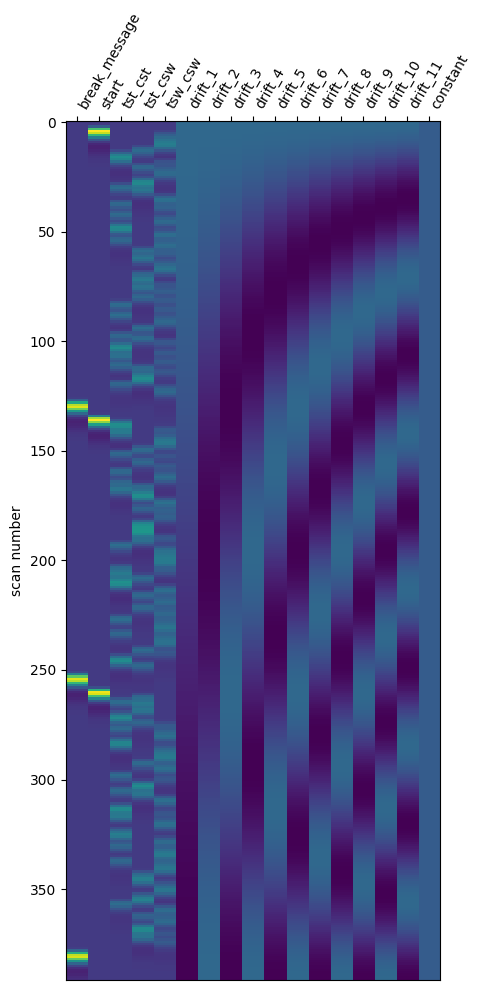

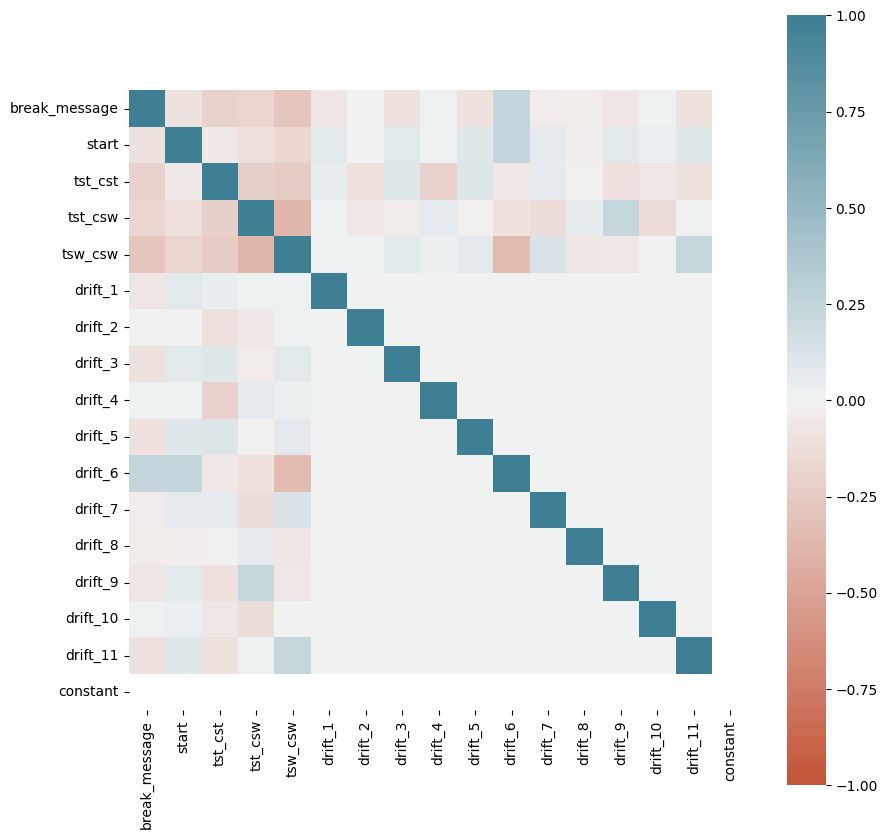

In [6]:
events_ts = make_cued_spatial_ts_timings(**events_inputs)
_, _, desmat = est_eff_and_vif(
    events_ts, tr, total_time, contrasts, time_past_last_offset=20, deriv=False
)

plot_design_matrix(desmat)
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    desmat.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax,
)
plt.show()

In [7]:
nsim = 250
output_setting1, events_setting1 = run_eff_sim(
    nsim,
    events_inputs,
    make_cued_spatial_ts_timings,
    contrasts,
    avg_trial_repeats_info,
    tr,
    total_time,
    trials_psych_assess_map,
    avg_prob_given_last1,
    avg_prob_given_last2,
    time_past_last_offset=20,
    deriv=False,
)

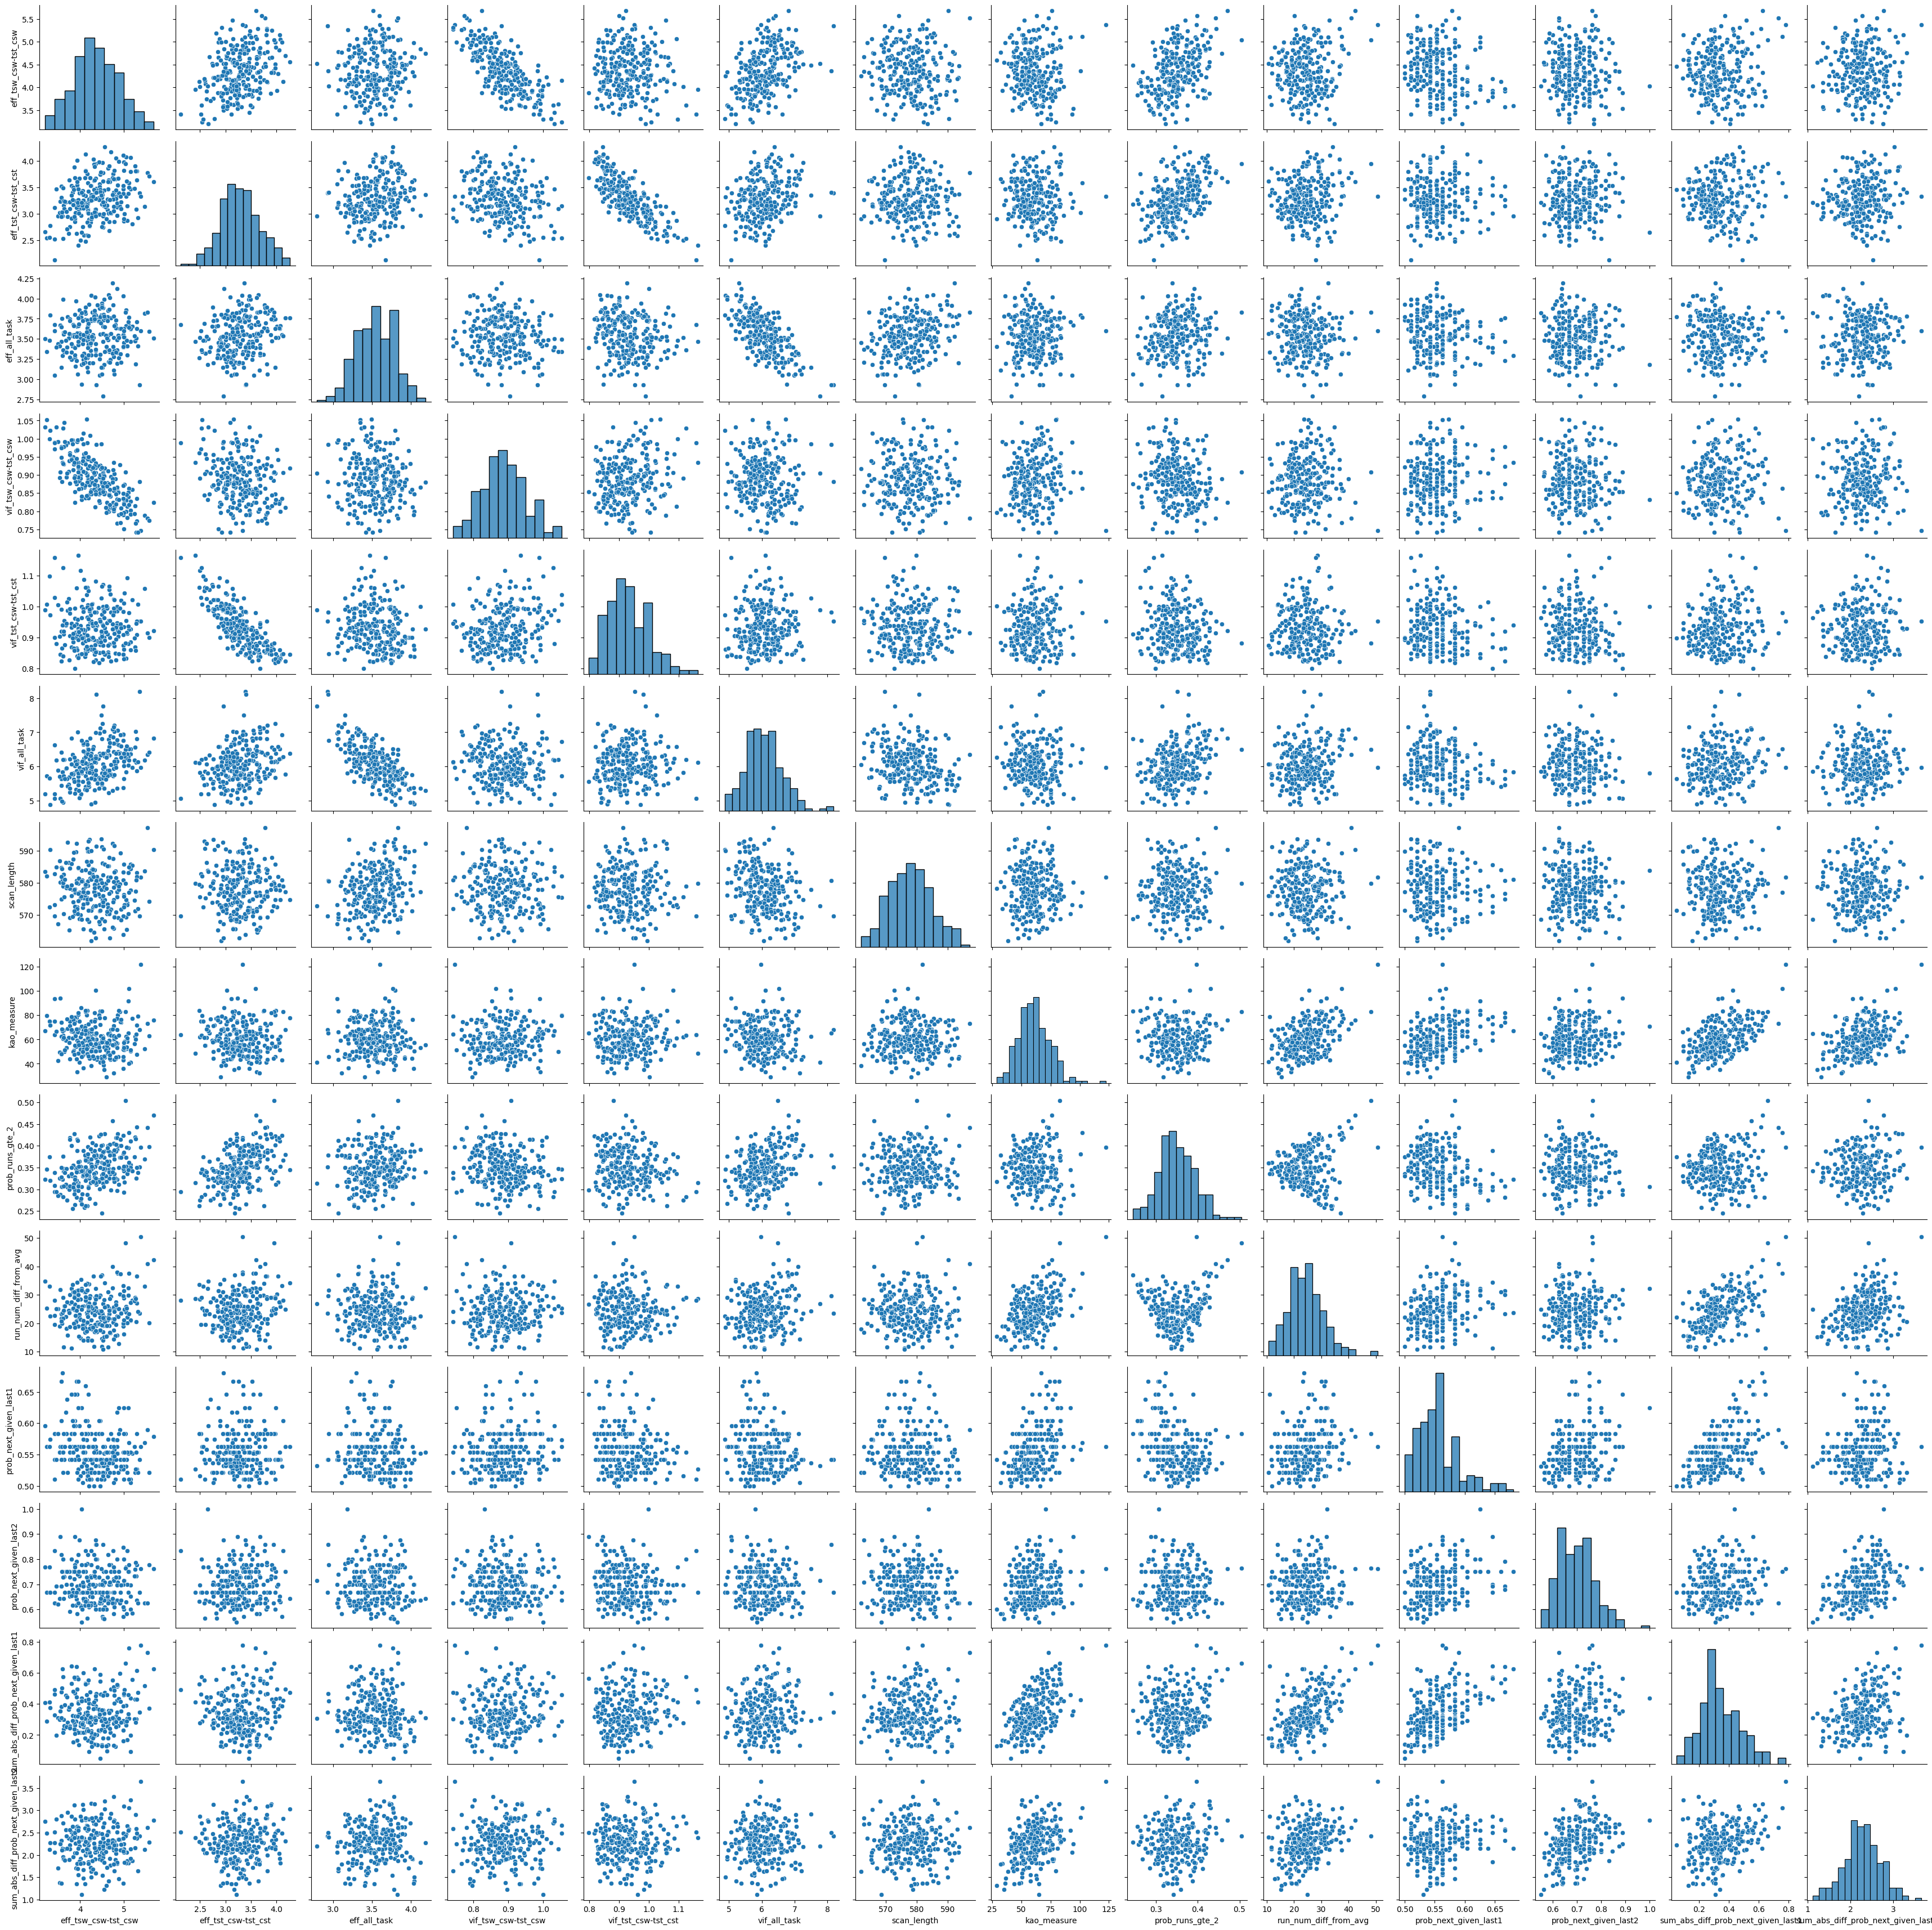

In [8]:
g = sns.PairGrid(output_setting1)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.savefig('/Users/jeanettemumford/Desktop/junk.pdf', format='pdf', bbox_inches='tight')

In [9]:
pd.set_option('display.width', 1000)
eff_vif_summaries = {}

eff_vif_summaries['setting1'] = np.round(
    output_setting1[
        [
            'eff_tsw_csw-tst_csw',
            'eff_tst_csw-tst_cst',
            'eff_all_task',
            'vif_tsw_csw-tst_csw',
            'vif_tst_csw-tst_cst',
            'vif_all_task',
            'scan_length',
        ]
    ].quantile(q=[0.05, 0.5, 0.95]),
    2,
)

print('95th percentile of efficiencies')
print(eff_vif_summaries['setting1'])

95th percentile of efficiencies
      eff_tsw_csw-tst_csw  eff_tst_csw-tst_cst  eff_all_task  vif_tsw_csw-tst_csw  vif_tst_csw-tst_cst  vif_all_task  scan_length
0.05                 3.57                 2.64          3.15                 0.79                 0.84          5.22       567.16
0.50                 4.34                 3.27          3.54                 0.88                 0.92          6.05       577.88
0.95                 5.22                 3.96          3.92                 1.00                 1.06          7.02       590.34


Similar to the stop signal task, this one doesn't have much baseline, which is why the task vs baseline has a high VIF.  That said, the other two contrasts look great and there's very low pairwise correlations present, so I feel the VIFs for the condition comparison contrasts are trustworthy.

Previously (with stop signal) we found that adding baseline before/after the message was the most impactful, so I'll try that here.  Note, that with the stop signal task we stuck with the original break fixation of 6s because the VIF range for task vs baseline had values below 5, which allowed us to choose good designs from a large pool of designs.  Here the 5th percentile is almost 6, so we cannot do the same thing with this task.

### Add more baseline


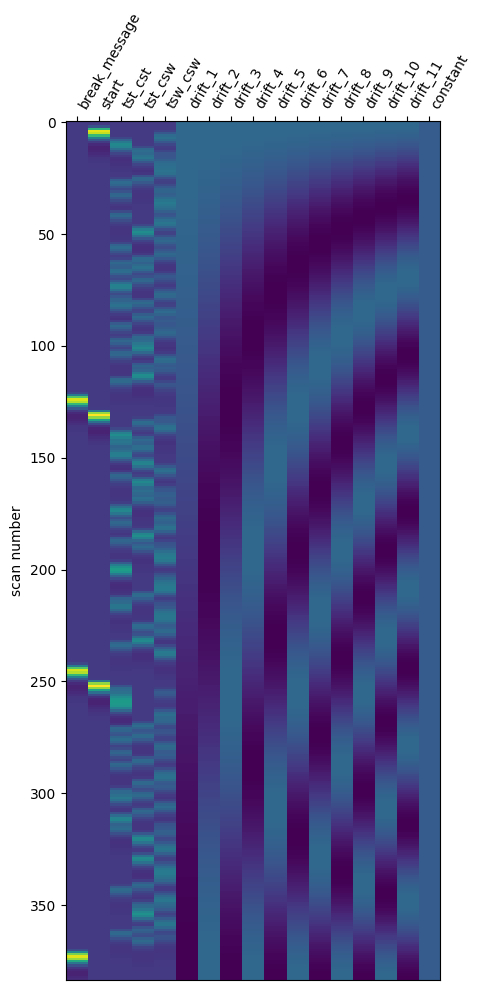

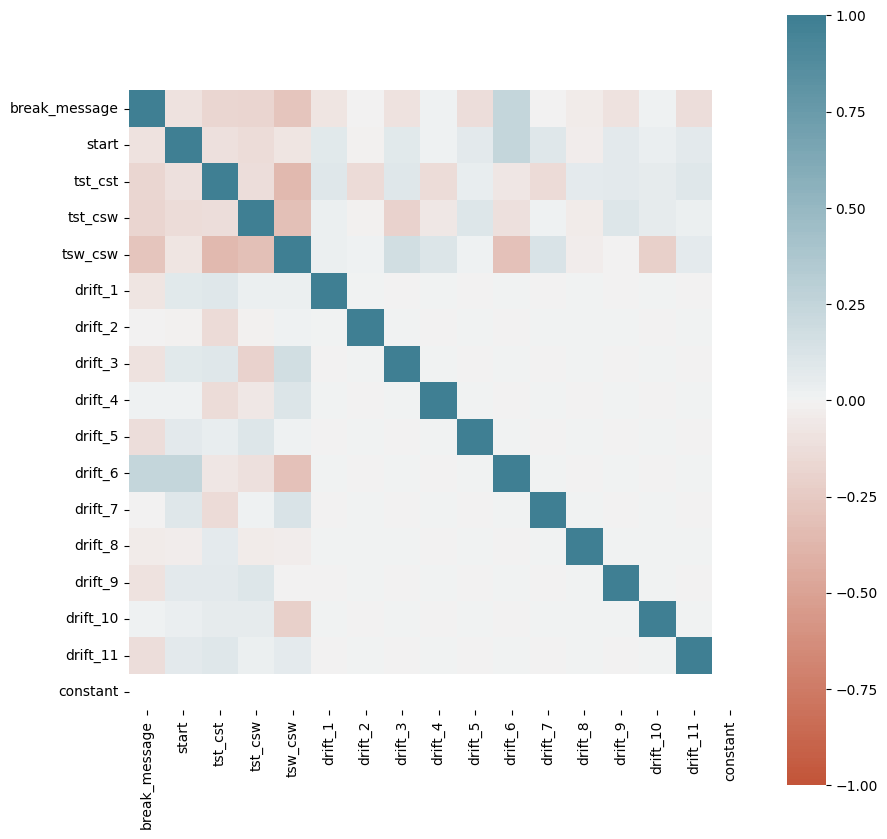

In [10]:
events_inputs_break_baseline_8 = {
    'n_tsw_csw': 96,
    'n_tst_cst': 48,
    'n_tst_csw': 48,
    'nbreaks': 2,
    'cue_stim_dur': 1.15,
    'blank_dur': 0.5,
    'break_fix_pre_message_dur': 7,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 7,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': 0.5,
}

events_ts_break_baseline_8 = make_cued_spatial_ts_timings(
    **events_inputs_break_baseline_8
)
_, _, desmat_break_baseline_8 = est_eff_and_vif(
    events_ts_break_baseline_8,
    tr,
    total_time,
    contrasts,
    time_past_last_offset=20,
    deriv=False,
)

plot_design_matrix(desmat_break_baseline_8)
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    desmat_break_baseline_8.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax,
)
plt.show()

In [11]:
nsim = 250
output_break_baseline_8, events_break_baseline_8 = run_eff_sim(
    nsim,
    events_inputs_break_baseline_8,
    make_cued_spatial_ts_timings,
    contrasts,
    avg_trial_repeats_info,
    tr,
    total_time,
    trials_psych_assess_map,
    avg_prob_given_last1,
    avg_prob_given_last2,
    time_past_last_offset=20,
    deriv=False,
)

In [12]:
eff_vif_summaries['setting_break_baseline_8'] = np.round(
    output_break_baseline_8[
        [
            'eff_tsw_csw-tst_csw',
            'eff_tst_csw-tst_cst',
            'eff_all_task',
            'vif_tsw_csw-tst_csw',
            'vif_tst_csw-tst_cst',
            'vif_all_task',
            'scan_length',
        ]
    ].quantile(q=[0.05, 0.5, 0.95]),
    2,
)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_tsw_csw-tst_csw  eff_tst_csw-tst_cst  eff_all_task  vif_tsw_csw-tst_csw  vif_tst_csw-tst_cst  vif_all_task  scan_length
0.05                 3.57                 2.64          3.15                 0.79                 0.84          5.22       567.16
0.50                 4.34                 3.27          3.54                 0.88                 0.92          6.05       577.88
0.95                 5.22                 3.96          3.92                 1.00                 1.06          7.02       590.34
Results for setting_break_baseline_8
      eff_tsw_csw-tst_csw  eff_tst_csw-tst_cst  eff_all_task  vif_tsw_csw-tst_csw  vif_tst_csw-tst_cst  vif_all_task  scan_length
0.05                 3.64                 2.71          3.59                 0.80                 0.83          4.58       572.33
0.50                 4.28                 3.19          3.93                 0.88                 0.93          5.38       583.28
0.95                 5.19       

That didn't help so much, so I'll try adding to the fixation between trials

### More fixation between trials

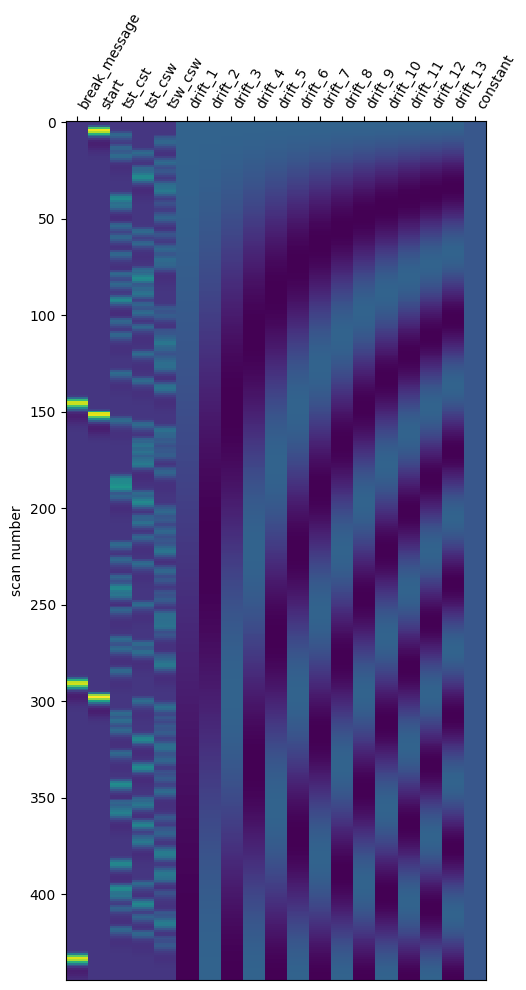

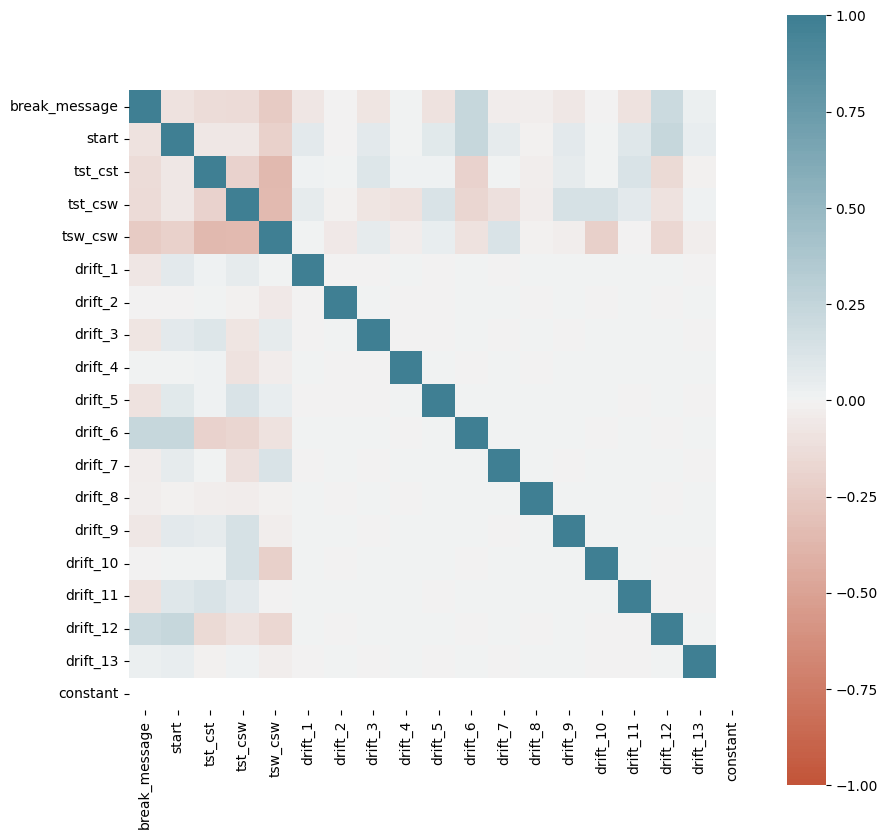

In [13]:
events_inputs_isi_1_5s = {
    'n_tsw_csw': 96,
    'n_tst_cst': 48,
    'n_tst_csw': 48,
    'nbreaks': 2,
    'cue_stim_dur': 1.15,
    'blank_dur': 0.5,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 1,
    'isi_truncation': 4.5,
    'isi_shift': 0.5,
}

events_ts_isi_1_5s = make_cued_spatial_ts_timings(**events_inputs_isi_1_5s)
_, _, desmat_isi_1_5s = est_eff_and_vif(
    events_ts_isi_1_5s, tr, total_time, contrasts, time_past_last_offset=20, deriv=False
)

plot_design_matrix(desmat_isi_1_5s)
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    desmat_isi_1_5s.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax,
)
plt.show()

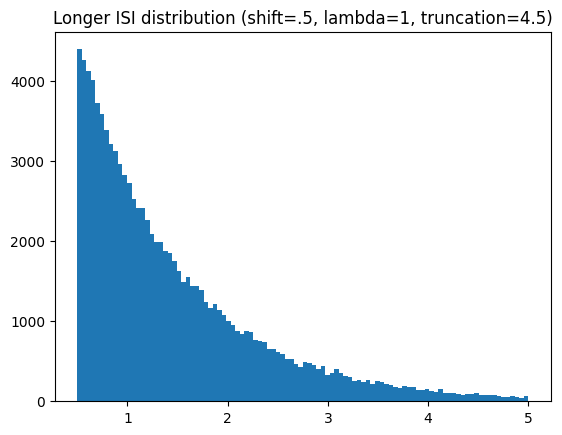

theoretical mean
1.449447932838815
quartiles
[0.5   0.781 1.181 1.859 5.   ]


In [14]:
nsamp = 100000
samples, theoretical_mean = sample_shifted_truncated_exponential(
    events_inputs_isi_1_5s['isi_exp_lam'],
    events_inputs_isi_1_5s['isi_truncation'],
    events_inputs_isi_1_5s['isi_shift'],
    nsamp,
)
isi_quartiles = np.round(np.quantile(samples, [0, 0.25, 0.5, 0.75, 1]), 3)

plt.hist(samples, 100)
plt.title('Longer ISI distribution (shift=.5, lambda=1, truncation=4.5)')
plt.show()
print('theoretical mean')
print(theoretical_mean)
print('quartiles')
print(isi_quartiles)

In [15]:
nsim = 250
output_isi_1_5s, events_isi_1_5s = run_eff_sim(
    nsim,
    events_inputs_isi_1_5s,
    make_cued_spatial_ts_timings,
    contrasts,
    avg_trial_repeats_info,
    tr,
    total_time,
    trials_psych_assess_map,
    avg_prob_given_last1,
    avg_prob_given_last2,
    time_past_last_offset=20,
    deriv=False,
)

In [16]:
eff_vif_summaries['setting_isi 1.5s'] = np.round(
    output_isi_1_5s[
        [
            'eff_tsw_csw-tst_csw',
            'eff_tst_csw-tst_cst',
            'eff_all_task',
            'vif_tsw_csw-tst_csw',
            'vif_tst_csw-tst_cst',
            'vif_all_task',
            'scan_length',
        ]
    ].quantile(q=[0.05, 0.5, 0.95]),
    2,
)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_tsw_csw-tst_csw  eff_tst_csw-tst_cst  eff_all_task  vif_tsw_csw-tst_csw  vif_tst_csw-tst_cst  vif_all_task  scan_length
0.05                 3.57                 2.64          3.15                 0.79                 0.84          5.22       567.16
0.50                 4.34                 3.27          3.54                 0.88                 0.92          6.05       577.88
0.95                 5.22                 3.96          3.92                 1.00                 1.06          7.02       590.34
Results for setting_break_baseline_8
      eff_tsw_csw-tst_csw  eff_tst_csw-tst_cst  eff_all_task  vif_tsw_csw-tst_csw  vif_tst_csw-tst_cst  vif_all_task  scan_length
0.05                 3.64                 2.71          3.59                 0.80                 0.83          4.58       572.33
0.50                 4.28                 3.19          3.93                 0.88                 0.93          5.38       583.28
0.95                 5.19       

## Look at setting 1, but trim end to 10s from 20s from last offset

In [17]:
events_inputs = {
    'n_tsw_csw': 96,
    'n_tst_cst': 48,
    'n_tst_csw': 48,
    'nbreaks': 2,
    'cue_stim_dur': 1.15,
    'blank_dur': 0.5,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': 0.5,
}

nsim = 250
output_setting1_10s, events_setting1_10s = run_eff_sim(
    nsim,
    events_inputs,
    make_cued_spatial_ts_timings,
    contrasts,
    avg_trial_repeats_info,
    tr,
    total_time,
    trials_psych_assess_map,
    avg_prob_given_last1,
    avg_prob_given_last2,
    time_past_last_offset=10,
    deriv=False,
)

In [18]:
eff_vif_summaries['setting 1 with 10s'] = np.round(
    output_setting1_10s[
        [
            'eff_tsw_csw-tst_csw',
            'eff_tst_csw-tst_cst',
            'eff_all_task',
            'vif_tsw_csw-tst_csw',
            'vif_tst_csw-tst_cst',
            'vif_all_task',
            'scan_length',
        ]
    ].quantile(q=[0.05, 0.5, 0.95]),
    2,
)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_tsw_csw-tst_csw  eff_tst_csw-tst_cst  eff_all_task  vif_tsw_csw-tst_csw  vif_tst_csw-tst_cst  vif_all_task  scan_length
0.05                 3.57                 2.64          3.15                 0.79                 0.84          5.22       567.16
0.50                 4.34                 3.27          3.54                 0.88                 0.92          6.05       577.88
0.95                 5.22                 3.96          3.92                 1.00                 1.06          7.02       590.34
Results for setting_break_baseline_8
      eff_tsw_csw-tst_csw  eff_tst_csw-tst_cst  eff_all_task  vif_tsw_csw-tst_csw  vif_tst_csw-tst_cst  vif_all_task  scan_length
0.05                 3.64                 2.71          3.59                 0.80                 0.83          4.58       572.33
0.50                 4.28                 3.19          3.93                 0.88                 0.93          5.38       583.28
0.95                 5.19       